In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
conn = mysql.connector.connect(host = "localhost",
                               username= "root",
                               password = "A*123456a",
                               database="ecommerce")

cur=conn.cursor()


# List all unique cities where customers are located.

In [4]:
query="""SELECT DISTINCT(customer_city) FROM customers"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [6]:
query="""SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""
cur.execute(query)
data=cur.fetchall()
print(data[0][0],"orders were placed in 2017")

45101 orders were placed in 2017


# Find the total sales per category

In [8]:
query= """SELECT UPPER(products.product_category) AS category, ROUND(SUM(payments.payment_value),2) FROM products JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id GROUP BY category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","Sales"])
df

,category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [10]:
query ="""SELECT (SUM((CASE
                  WHEN payment_installments >=1 THEN 1
                  ELSE 0
                  END))/COUNT(*))*100 FROM payments""" 
cur.execute(query)
data=cur.fetchall()
print("percentage of orders that were paid in installments were",data[0][0],"%")

percentage of orders that were paid in installments were 99.9981 %


# Count the number of customers from each state

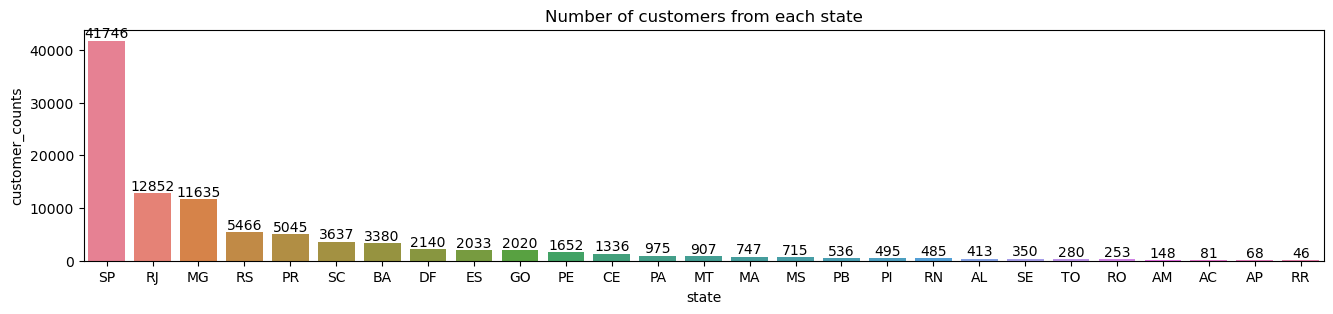

In [12]:
query="""SELECT customer_state,COUNT(customer_id) FROM customers GROUP BY customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_counts"])
df=df.sort_values(by="customer_counts",ascending=False)

plt.figure(figsize=(16,3))
a=sns.barplot(x=df["state"],y=df["customer_counts"],data=df,hue="state")
for bars in a.containers:
    a.bar_label(bars)
plt.title("Number of customers from each state")
plt.show()
        

# Calculate the number of orders per month in 2018

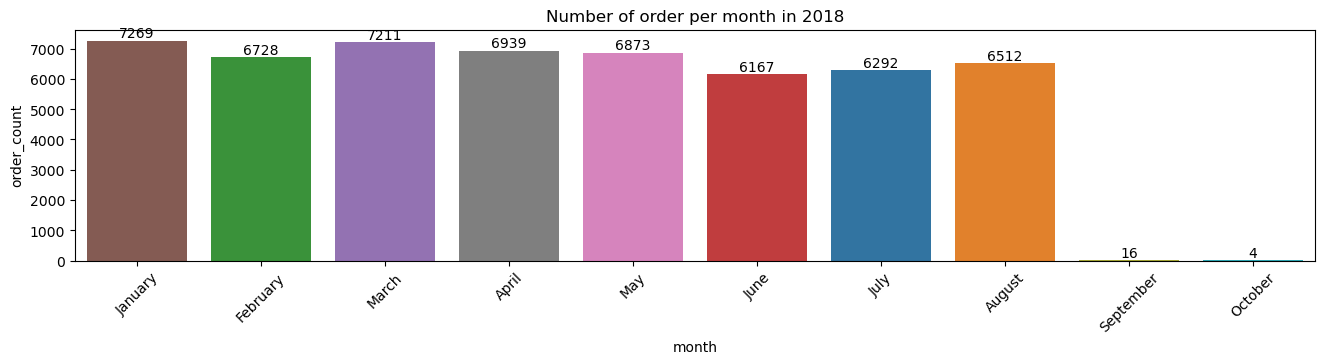

In [14]:
query="""SELECT MONTHNAME(order_purchase_timestamp) as month, COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2018 GROUP BY month"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["month","order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

plt.figure(figsize=(16,3))
a=sns.barplot(x=df["month"],y=df["order_count"],data=df,hue="month",order=o)
for bars in a.containers:
    a.bar_label(bars)
plt.title("Number of order per month in 2018")
plt.xticks(rotation=45)
plt.show()
        

# Find the average number of products per order, grouped by customer city

In [16]:
query="""with count_per_order as
(SELECT orders.order_id, orders.customer_id , COUNT(order_items.order_id) AS oc 
 FROM orders join order_items
 ON orders.order_id = order_items.order_id
 GROUP BY orders.order_id, orders.customer_id)      

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) AS average_orders FROM customers JOIN count_per_order on customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY average_orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer city","avg products per order"])
df.head(10)

,customer city,avg products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category

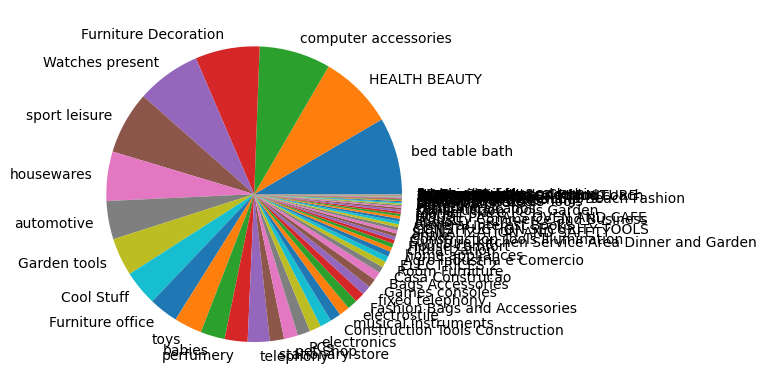

In [18]:
query="""SELECT products.product_category as category, ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) as percen_revenue_per_category 
FROM products JOIN order_items ON products.product_id=order_items.product_id JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category ORDER BY percen_revenue_per_category DESC"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","percentage revenue per category"])
plt.pie(df["percentage revenue per category"],labels=df["category"])
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased

In [20]:
query = """SELECT products.product_category, 
COUNT(order_items.product_id),
ROUND(AVG(order_items.price),2)
FROM products JOIN order_items
ON products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","product_count","price"])

corr=np.corrcoef(df["price"],df["product_count"])
print("correlation is",corr[0][-1])

correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

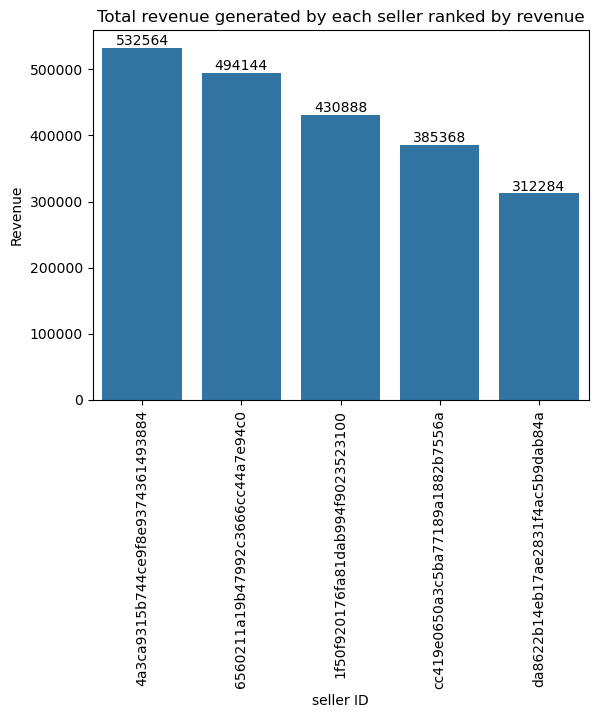

In [22]:
query="""SELECT *, dense_rank() OVER(ORDER BY revenue DESC) AS rn FROM 
(SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue FROM order_items JOIN payments ON order_items.order_id=payments.payment_value 
GROUP BY order_items.seller_id) AS a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller ID","Revenue","Rank"])
df=df.head()
a=sns.barplot(x=df["seller ID"],y=df["Revenue"],data=df)
for bars in a.containers:
    a.bar_label(bars)
plt.title("Total revenue generated by each seller ranked by revenue")
plt.xticks(rotation=90)
plt.show()



# Calculate the moving average of order values for each customer over their order history

In [24]:
query="""SELECT *,AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp) AS mov_avg FROM 
(SELECT orders.customer_id,payments.payment_value AS payment,orders.order_purchase_timestamp FROM orders JOIN payments 
ON orders.order_id = payments.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer ID","payment_value","order_purchase_timestamp","mov_avg"])
df

,customer ID,payment_value,order_purchase_timestamp,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,114.74,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,67.41,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,195.42,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,179.35,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,107.01,2018-04-02 13:42:17,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,71.23,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,63.13,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,214.13,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,45.50,2017-09-02 11:53:32,45.500000


# Calculate the cumulative sales per month for each year

In [26]:
query="""SELECT year,month,payment,SUM(payment) OVER(ORDER BY year,month) AS cum_sales FROM 
(SELECT YEAR(orders.order_purchase_timestamp) AS year, MONTH(orders.order_purchase_timestamp) as month,ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY year, month order by year, month) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["YEAR","MONTH","payment","cum_sales"])
df

,YEAR,MONTH,payment,cum_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales

In [28]:
query="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [30]:
query="""with a as (select customers.customer_id, MIN(orders.order_purchase_timestamp) as first_order from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order from a join orders 
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp> first_order
and orders.order_purchase_timestamp< date_add(first_order,interval 6 month)
group by a.customer_id)

select (count(distinct a.customer_id)/count(distinct b.customer_id))*100 from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year

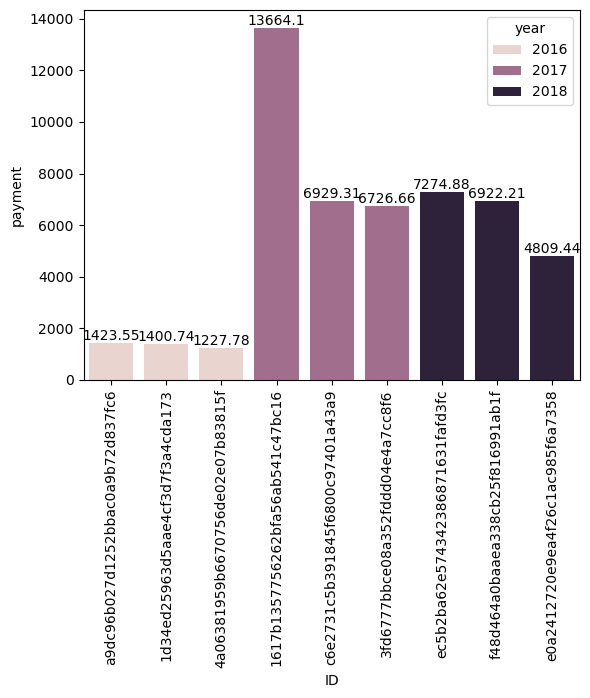

In [32]:
query="""select * from
(select year(orders.order_purchase_timestamp) as year,orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as rn
from orders join payments 
on orders.order_id = payments.order_id
group by year,orders.customer_id) as a
where rn <=3"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["year","ID","payment","rank"])
ax=sns.barplot(x=df["ID"],y=df["payment"],data=df,hue="year")
for bars in ax.containers:
    ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()